In [4]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_lopt import *
#from lib.lib_shape import *

In [5]:
v_list=random_projections(2,5,0)
v_list.mean(0)

array([0.84535174, 0.09057646])

In [29]:
#running time 
#Lambda=20.0
step_size=50

n_list=np.array(range(200,1100,step_size))

K_list=np.array(range(5,20,5))
Lambda_list=[5.0]
l=10
save_dict={}
id2=np.eye(2)
for K in K_list:
    mean_list=random_projections(2,K,0)*np.sqrt(3)
    mean_bar=np.mean(mean_list,0)
    List_ij=[]
    for i in range(K):
        for j in range(i+1,K):
            List_ij.append((i,j))
    n_compute=len(List_ij)

    for Lambda in Lambda_list:
        opt_time1=np.zeros((n_list.shape[0],l))
        opt_time2=np.zeros((n_list.shape[0],l))
        for epoch in range(n_list.shape[0]):
            n=n_list[epoch]
            print('n',n)
            for l_p in range(l):
                #generate data
                X_list=list()
                p_list=list()
                for i in range(K):
                    Xi=np.random.multivariate_normal(mean_list[i],id2,n)
                    X_list.append(Xi)    
                    p_list.append(np.ones(n))
                X_list=np.stack(X_list)
                p_list=np.stack(p_list)

                p0=np.ones(n)

                # compute OPT distance pairwisely
                t_start=time.time()
                for k in range(n_compute):
                    i,j=List_ij[k]
                    X1=X_list[i]
                    X2=X_list[j]
                    p1=p_list[i]
                    p2=p_list[j]          
                    cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=200000)
                t_end=time.time()
                opt_time1[epoch,l_p]=t_end-t_start

                # compute lopt embedding
                X01=np.random.multivariate_normal(mean_bar,id2,n)
                t_start=time.time()
                opt_embedding_list=[]
                for i in range(K):
                    Xi=X_list[i]
                    pi=p_list[i]
                    Ui,pi_hat,Mi=lopt_embedding(X01,Xi,p0,pi,Lambda)
                    opt_embedding_list.append((Ui,pi_hat,Mi))
                for k in range(n_compute):
                    i,j=List_ij[k]
                    Ui,pi_hat,Mi=opt_embedding_list[i]
                    Uj,pj_hat,Mj=opt_embedding_list[j]
                    cost2,penualty2=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                t_end=time.time()
                opt_time2[epoch,l_p]=t_end-t_start


        save_dict['K='+str(K)+',Lambda='+str(Lambda)+',time1']=opt_time1
        save_dict['K='+str(K)+',Lambda='+str(Lambda)+',time2']=opt_time2
        
torch.save(save_dict,'experiment/performance/time_list.pt')


n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
n 1050
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
n 1050
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
n 1050


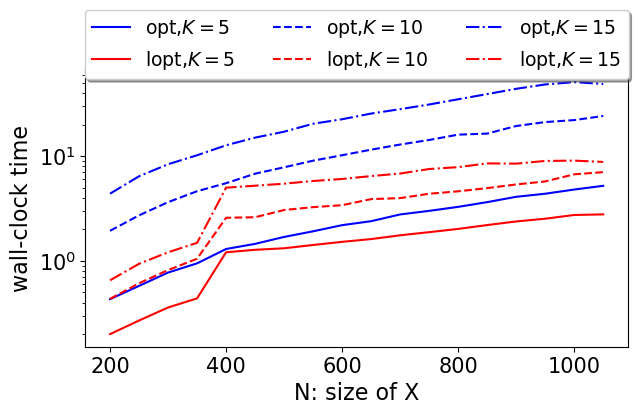

done


In [10]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '--', '-.', '.-']
fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)
K_list=np.array(range(5,20,5))
ind=0
save_dict=torch.load('experiment/performance/time_list.pt')
Lambda_list=[5.0]
step_size=50
n_list=np.array(range(200,1100,step_size))

for K in K_list:
    for Lambda in Lambda_list:
        opt_time1=save_dict['K='+str(K)+',Lambda='+str(Lambda)+',time1']
        opt_time2=save_dict['K='+str(K)+',Lambda='+str(Lambda)+',time2']
        mean_1=opt_time1.mean(1)
        mean_2=opt_time2.mean(1)        
        ax.semilogy(n_list,mean_1,linestyle_array[ind],color='blue',label=r'opt,$K=%d$'%(K))
        ax.semilogy(n_list,mean_2,linestyle_array[ind],color='red',label=r'lopt,$K=%d$'%(K))
    
        ind+=1

#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel("N: size of X",fontsize=16)
plt.ylabel("wall-clock time",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25),
          fancybox=True, shadow=True, ncol=3,fontsize=13.6)
plt.savefig('experiment/performance/time.pdf',format="pdf",dpi=800,bbox_inches='tight')
plt.show()
print('done')